## Mapping 

RUN THIS NOTEBOOK TO CALCULATE HOW MUCH PERFORMANCE AND WITHDRAWAL FRIKTION HAS GENERATED. 

DEPENDS ON MANUALLY MAINTAINED LIST OF VOLT ADDRESSES. TO TRACK NEW ONES, NEED TO UPDATE THE MAPPING. 

In [1]:
import pandas as pd
import requests
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': 'BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4'}
    request = requests.post('https://graphql.bitquery.io/', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        print(request.reason)
        raise Exception('Query failed and return code is {}.{}'.format(request.status_code, query))

query_date = '"2021-12-16", "{}"'.format(str(datetime.date.today()))

# Convert this to JSON

VOLT_ACCOUNTS = {
    # CSP
    "SOL-P": "6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK",
    "SOL-P-high": "JAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf",
    "BTC-P": "GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f",
    "SOL-P (tsUSDC)": "AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8",
    "ETH-P": "EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax",
    "LUNA-P": "5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj",
    "MNGO-P": "CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6",
#     "SOL-P-Step": ,
#     "SOL-P-Parrot": ,
#     "SOL-P-UXD": ,
    
    "SOL-C": "Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G",
    "SOL-C-high": "DNa849drqW19uBV5X9ohpJ5brRGzq856gk3HDRqveFrA",
    "BTC-C": "DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du",
    "mSOL-C": "6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH",
    "ETH-C": "FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp",
    "FTT-C": "7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K",
    "SRM-C": "2P427N5sYcEXvZAZwqNzjXEHsBMESQoLyjNquTSmGPMb",
    "MNGO-C": "B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ",
    "scnSOL-C": "A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A",
    "SBR-C": "BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h",
    "LUNA-C": "5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X",
    "RAY-C": "A6XsYxGj9wpqUZG81XwgQJ2zJ3efCbuWSQfnkHqUSmdM",
    "STEP-C": "FiEHDTKT6X7VFwGaUmsm1XXYr8vvkoSR5EqcY4znpefq",
    "AVAX-C": "HLfkEc6E2HEcABaWm3QZSfDvswzXjh1onF9xEzUAtWNS",
}

ACCOUNT_STRING = str(list(VOLT_ACCOUNTS.values())).replace("\'", "\"")

FEES_ADDRESS = '3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ'

MASTER_ADDRESS = 'DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE'

query = """
    query{
    solana(network: solana) {
    transfers(
      date: {between: ["""+ query_date +"""]}
      transferType: {is: transfer}
      any: [{senderAddress: {in: """ + ACCOUNT_STRING + """}}]
    ) {
      amount
      currency {
        symbol
        address
      }
      block {
        timestamp {
          iso8601
        }
      }
      transaction {
        signer
        signature
        innerInstructionsCount
      }
      receiver {
        address
      }
      sender {
        address
      }
    }
  }
}
"""

result = run_query(query)
# convert GraphQL json to pandas dataframe
df = pd.json_normalize(result['data']['solana']['transfers'])
df = df.rename(columns={"block.timestamp.iso8601": "date", "currency.symbol": "symbol", 
                        "transaction.signer":"signer", "currency.address":"cash",
                        "receiver.address":"receiver", "sender.address":"asset", "transaction.signature": "tx_id"})
# Does json_normalize flatten a json file for you??

df["tx_id"] = df["tx_id"].apply(lambda x: "https://solscan.io/tx/{}".format(x))
# if transaction signer & receiver is diff, drop row
df = df.query("receiver == '{}'".format(FEES_ADDRESS)).reset_index(drop=True)

def find_key(value, d): 
    for k, v in d.items():
        if value == v:
            return k

df['asset'] = df.asset.apply(lambda x: find_key(x, VOLT_ACCOUNTS))

df['symbol'] = df.apply(lambda x: "tsUSDC" if x.cash == "Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip" else x.symbol, axis=1)

df["FeeType"] = df["transaction.innerInstructionsCount"].apply(lambda x: "Withdrawal Fee" if x==1 else "Performance Fee")

In [2]:
df.groupby(["FeeType", "symbol"]).amount.sum()

FeeType          symbol
Performance Fee  BTC           1.388323
                 ETH           4.292708
                 FTT         531.417061
                 LUNA        504.763571
                 MNGO      22098.953302
                 RAY         231.926626
                 SBR       85893.930697
                 SOL        1735.005001
                 SRM       20159.080000
                 STEP        725.778038
                 USDC      58689.701570
                 UST        3912.364308
                 mSOL        561.077512
                 scnSOL       62.217521
                 tsUSDC     8290.858470
Withdrawal Fee   BTC           0.263747
                 ETH           1.546723
                 FTT          61.220766
                 LUNA         94.975402
                 MNGO       3499.265779
                 RAY           4.801589
                 SBR        6783.790275
                 SOL         154.272594
                 SRM         219.827571
                

# Get current coin prices porfolio calculation

In [741]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import ccxt

import datetime

cftx = ccxt.ftx(
    {
        "apiKey":"mvnd3WRG56rAP-6MpxFyZ5sN2WnjEO8UsQB6u-6s",
        "secret":"m_m926E36IMlrhCv6bGkLdSdaVegbm5PggpCrFCM"
    }
)

markets = cftx.load_markets()
binance = ccxt.binance()

# 10 days
time_since = datetime.datetime.timestamp(datetime.datetime.now())*1000-10*24*60*60*1000

symbols = {
    "BTC": "BTC/USD", 
    "ETH": "ETH/USD", 
    "SOL": "SOL/USD", 
    "MSOL": "MSOL/USD", 
    "LUNA": "LUNA/USD:USD", 
    "FTT": "FTT/USD", 
    "SRM": "SRM/USD",
    "MNGO": "MNGO/USD",
    "RAY": "RAY/USD", 
    "STEP": "STEP/USD",
    "AVAX": "AVAX/USD"
}
pricedf = {}
for k, symbol in symbols.items():
    data = cftx.fetchOHLCV(symbol, '1m', since=time_since, limit=1)
    tree = pd.DataFrame(data, columns=["time", "open", "high", "low", "close", "volume"])
    data
    print(data)
    pricedf[k] = tree["close"]
    

[[1647581820000, 40742.0, 40755.0, 40742.0, 40754.0, 23961.9971]]
[[1647581820000, 2793.4, 2794.1, 2793.2, 2794.1, 12245.9099]]
[[1647581820000, 86.305, 86.42, 86.305, 86.41, 22001.560525]]
[[1647581820000, 89.25, 89.425, 89.25, 89.425, 0.0]]
[[1647581820000, 85.995, 86.045, 85.989, 86.035, 30080.0032]]
[[1647581820000, 42.901, 42.915, 42.901, 42.915, 283.1814]]
[[1647581820000, 1.869, 1.869, 1.869, 1.869, 0.0]]
[[1647581820000, 0.150175, 0.150175, 0.150175, 0.150175, 0.0]]
[[1647581820000, 2.4685, 2.4705, 2.4685, 2.4705, 7.4076]]
[[1647581820000, 0.153, 0.153, 0.153, 0.153, 107.8956]]
[[1647581820000, 79.202, 79.265, 79.202, 79.265, 0.0]]


In [742]:
# Random price hardcodes b/c they aren't traded on FTX

pricedf["USDC"] =pricedf["tsUSDC"] = pricedf["UST"] = 1
pricedf["mSOL"] = pricedf["SOL"]*1.03
pricedf["scnSOL"] = pricedf["SOL"]*1.03
pricedf["SBR"] = 0.04000

# ALLS

In [743]:
fees = df.groupby(["FeeType", "symbol"]).amount.sum().reset_index()

tree = pd.DataFrame(pricedf).T.reset_index()

tree.columns = ["symbol", "price"]

xavier = pd.merge(fees, tree, on="symbol", how='left')

xavier["usdc_value"] = (xavier["amount"]*xavier["price"]).astype('int')

xavier.groupby(["FeeType", "symbol"])[["amount", "usdc_value"]].sum()

amount  usdc_value
FeeType         symbol                          
Performance Fee BTC         1.388323       56579
                ETH         4.292708       11994
                FTT       531.417061       22805
                LUNA      504.763571       43427
                MNGO    22098.953302        3318
                RAY       231.926626         572
                SBR     85893.930697        3435
                SOL      1735.005001      149921
                SRM     20159.080000       37677
                STEP      725.778038         111
                USDC    58689.701570       58689
                UST      3912.364308        3912
                mSOL      561.077512       49937
                scnSOL     62.217521        5537
                tsUSDC   8290.858470        8290
Withdrawal Fee  BTC         0.263747       10748
                ETH         1.546723        4321
                FTT        61.220766        2627
                LUNA       94.975402        8171
                MNGO     3499.265779         525
                RAY         4.801589          11
                SBR      6783.790275         271
                SOL       154.272594       13330
                SRM       219.827571         410
                STEP       16.330453           2
                USDC    10912.415569       10912
                UST       425.566555         425
                mSOL      103.591086        9219
                scnSOL      5.353262         476
                tsUSDC   3349.411548        3349

In [744]:
xavier

,FeeType,symbol,amount,price,usdc_value
0,Performance Fee,BTC,1.388323,40754.000000,56579
1,Performance Fee,ETH,4.292708,2794.100000,11994
2,Performance Fee,FTT,531.417061,42.915000,22805
3,Performance Fee,LUNA,504.763571,86.035000,43427
4,Performance Fee,MNGO,22098.953302,0.150175,3318
5,Performance Fee,RAY,231.926626,2.470500,572
6,Performance Fee,SBR,85893.930697,0.040000,3435
7,Performance Fee,SOL,1735.005001,86.410000,149921
8,Performance Fee,SRM,20159.080000,1.869000,37677
9,Performance Fee,STEP,725.778038,0.153000,111


# If you want to mess with the actual withdrawals and performance fees, use this dataframe


## FeeType == "Performance Fee"


## FeeType == "Withdrawal Fee"

In [745]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   amount                              384 non-null    float64
 1   symbol                              384 non-null    object 
 2   cash                                384 non-null    object 
 3   date                                384 non-null    object 
 4   signer                              384 non-null    object 
 5   tx_id                               384 non-null    object 
 6   transaction.innerInstructionsCount  384 non-null    int64  
 7   receiver                            384 non-null    object 
 8   asset                               384 non-null    object 
 9   FeeType                             384 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 30.1+ KB


In [746]:
df.head(1)

,amount,symbol,cash,date,signer,tx_id,transaction.innerInstructionsCount,receiver,asset,FeeType
0,8.218337,tsUSDC,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,2022-02-06T02:35:21Z,GVs4XuqEC27ppPBsXocH6PNzLAaJhy8JjBZJdYzGbXnX,https://solscan.io/tx/4FhqyXunsNFivUtazhp6rqc5PQUADvFckV1NXrueAN1Dc5VG22brXDGVPSA5rSFb5rBA78wYY8eecfR2MJBMgaRc,4,3KjJiWBfaw96qGhysq6Fc9FTxdPgPTNY6shM7Bwfp8EJ,SOL-P (tsUSDC),Performance Fee


In [747]:
pdf = (pd.DataFrame(pricedf).T).reset_index()
pdf.columns=["symbol", "price"]

In [748]:
zz = pd.merge(df, pdf, on="symbol")

In [749]:
zz["usdc"] = zz["price"]*zz["amount"]

In [750]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

In [751]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)


formatter2 = FuncFormatter(thousands)

In [1060]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
def pct(x, pos):
    'The two args are the value and tick position'
    return '%1.1%%' % (x * 100)


formatter3 = FuncFormatter(pct)

Text(0.5, 1.0, 'USDC value of Friktion Fees by Date')

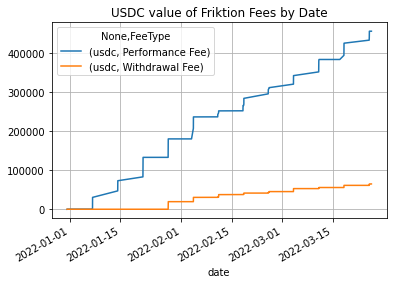

In [1061]:
zz.groupby(["date", "FeeType"])[["usdc"]].sum().unstack(1).fillna(0).cumsum().plot(grid=True)
plt.xticks(rotation=30)
plt.title("USDC value of Friktion Fees by Date")

In [1062]:
zz["churn"] = zz["usdc"]*1000

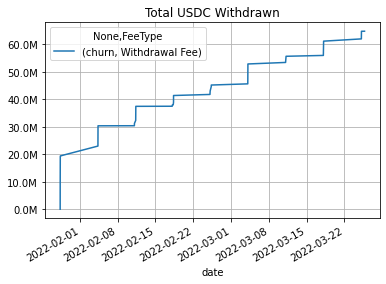

In [1063]:
ax = plt.figure().gca()
zz.loc[zz.FeeType=="Withdrawal Fee"].groupby(["date", "FeeType"])[["churn"]].sum().unstack(1).fillna(0).cumsum().plot(grid=True, ax=ax)
plt.xticks(rotation=30)
ax.set_title("Total USDC Withdrawn")
ax.yaxis.set_major_formatter(formatter)

In [1064]:
ff["datestr"] = pd.to_datetime(ff.time).dt.strftime("%Y-%m-%d")

In [1065]:
churn_rate = zz.loc[zz.FeeType=="Withdrawal Fee"].usdc.sum() / ff.groupby("datestr").tvl.mean().sum()

In [1066]:
perf_fee_rate = zz.loc[zz.FeeType=="Performance Fee"].usdc.sum()/ff.groupby("datestr").tvl.mean().sum()

In [1067]:
perf_fee_rate

5.2661076042275466e-05

In [1068]:
withdrawals = (1+np.arange(1, 279) * 0.01)*1.2e8

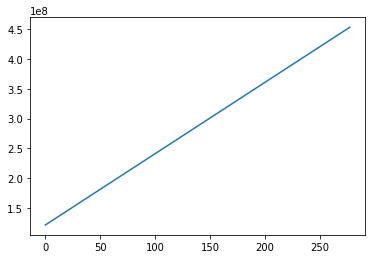

In [1069]:
plt.plot(withdrawals)

In [1070]:
withdrawals.sum()*churn_rate

597675.5958060542

In [1071]:
ff = pd.read_json("../derived_timeseries/tvl.json")

ff.columns=["time", "tvl"]

ff["time"] = ff.time.astype(dtype='datetime64[ms]')#.dt.strftime('%Y-%m-%d')

ff

,time,tvl
0,2021-12-25 00:27:14,2.922707e+07
1,2021-12-25 01:05:51,2.956973e+07
2,2021-12-25 01:37:17,2.982349e+07
3,2021-12-25 02:10:46,2.992262e+07
4,2021-12-25 03:01:37,2.976328e+07
...,...,...
16118,2022-03-27 05:27:10,1.137418e+08
16119,2022-03-27 05:34:29,1.138311e+08
16120,2022-03-27 05:44:18,1.137830e+08
16121,2022-03-27 05:53:08,1.137426e+08


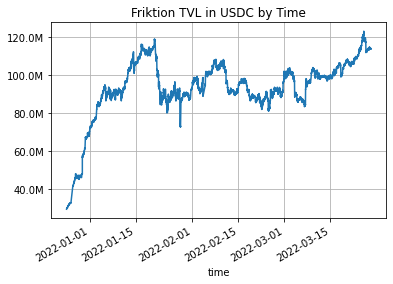

In [1072]:
ax = plt.figure().gca()
ff.groupby("time").tvl.mean().plot(grid=True, title="Friktion TVL in USDC by Time", ax=ax)
ax.yaxis.set_major_formatter(formatter)

In [1073]:
mean = ff.groupby("time").tvl.mean().reset_index()

In [1074]:
mean

,time,tvl
0,2021-12-25 00:27:14,2.922707e+07
1,2021-12-25 01:05:51,2.956973e+07
2,2021-12-25 01:37:17,2.982349e+07
3,2021-12-25 02:10:46,2.992262e+07
4,2021-12-25 03:01:37,2.976328e+07
...,...,...
16118,2022-03-27 05:27:10,1.137418e+08
16119,2022-03-27 05:34:29,1.138311e+08
16120,2022-03-27 05:44:18,1.137830e+08
16121,2022-03-27 05:53:08,1.137426e+08


In [1075]:
mean["2% annualized"]  = mean.tvl*0.02/365

In [1076]:
mean["1% annualized"]  = mean.tvl*0.01/365

<AxesSubplot:xlabel='time'>

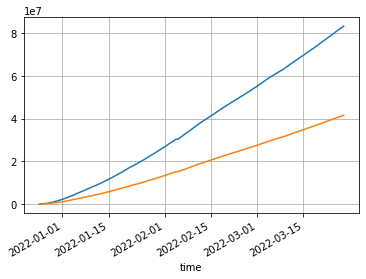

In [1077]:
mean.set_index("time")["2% annualized"].cumsum().plot(grid=True, label="2% annualized")
mean.set_index("time")["1% annualized"].cumsum().plot(grid=True, label="1% annualized")

# REAL STUF

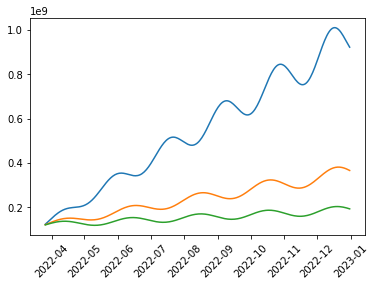

In [1078]:
y = pd.DataFrame(pd.date_range('2022-03-26', '2022-12-31'))

y.columns = ["date"]

y["future_tvl_bull"] = (1+np.arange(1, y.shape[0]+1) * 0.025)*1.2e8*(1+np.sin(y.index/8)*0.10)
y["future_tvl_realistic"] = (1+np.arange(1, y.shape[0]+1) * 0.007)*1.2e8*(1+np.sin(y.index/10)*0.10)
y["future_tvl_bear"] = (1+np.arange(1, y.shape[0]+1) * 0.002)*1.2e8*(1+np.sin(y.index/10)*0.10)

y = y.set_index("date")
plt.xticks(rotation=45)
plt.plot(y.future_tvl_bull)
plt.plot(y.future_tvl_realistic)
plt.plot(y.future_tvl_bear)

In [1079]:
zz["date"] = pd.to_datetime(zz.date)#.dt.strftime("%Y-%m-%d")

In [1080]:
qp = zz.groupby(["date", "FeeType"])[["usdc"]].sum().unstack(1).fillna(0).cumsum().reset_index()
qp.columns = qp.columns.get_level_values(0)

qp.columns = ["date", "performance_fee", "withdrawal_fee"]

In [1081]:
ff.groupby("time").tvl.mean()

time
2021-12-25 00:27:14    2.922707e+07
2021-12-25 01:05:51    2.956973e+07
2021-12-25 01:37:17    2.982349e+07
2021-12-25 02:10:46    2.992262e+07
2021-12-25 03:01:37    2.976328e+07
                           ...     
2022-03-27 05:27:10    1.137418e+08
2022-03-27 05:34:29    1.138311e+08
2022-03-27 05:44:18    1.137830e+08
2022-03-27 05:53:08    1.137426e+08
2022-03-27 06:06:19    1.137096e+08
Name: tvl, Length: 16123, dtype: float64

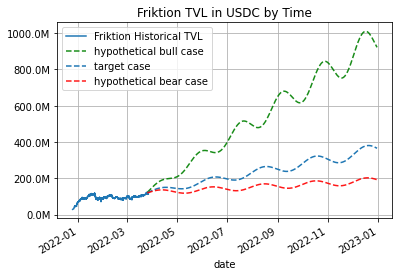

In [1082]:
ax = plt.figure().gca()
ff["time"] = pd.to_datetime(ff.time)
ff.groupby("time").tvl.mean().plot(grid=True, title="Friktion TVL in USDC by Time", ax=ax, label="Friktion Historical TVL", color='C0')

y.future_tvl_bull.plot(ax=ax, label="hypothetical bull case", linestyle='dashed', alpha=0.9, color='green')
y.future_tvl_realistic.plot(ax=ax, label="target case", linestyle='dashed', c='C0')
y.future_tvl_bear.plot(ax=ax, label="hypothetical bear case", linestyle='dashed', alpha=0.9, color='red')

plt.legend()
plt.grid(True)
ax.yaxis.set_major_formatter(formatter)

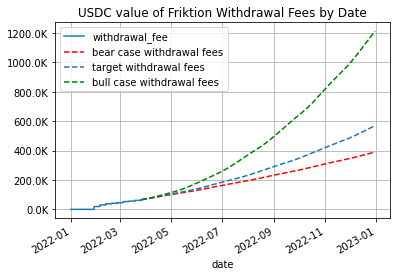

In [1083]:
ax = plt.figure().gca()

qp.set_index("date")[["withdrawal_fee"]].plot(grid=True, ax=ax)
plt.xticks(rotation=30)
ax.set_title("USDC value of Friktion Withdrawal Fees by Date")

ax.plot(y.future_tvl_bear.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="bear case withdrawal fees", linestyle='dashed', color='red')
ax.plot(y.future_tvl_realistic.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="target withdrawal fees", linestyle='dashed', color='C0')
ax.plot(y.future_tvl_bull.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="bull case withdrawal fees", linestyle='dashed', color='green')

plt.legend()

ax.yaxis.set_major_formatter(formatter2)

total_fees_bear = y.future_tvl_bear.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_bear.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]
total_fees_target = y.future_tvl_realistic.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_realistic.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]
total_fees_bull = y.future_tvl_bull.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_bull.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]

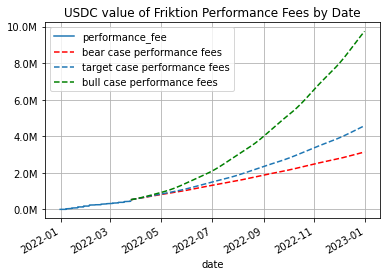

In [1084]:
ax = plt.figure().gca()

qp.set_index("date")[["performance_fee"]].plot(grid=True, ax=ax, label="realized performance fees")
plt.xticks(rotation=30)
ax.set_title("USDC value of Friktion Performance Fees by Date")

ax.plot(total_fees_bear, label="bear case performance fees", linestyle='dashed', color='red')
ax.plot(total_fees_target, label="target case performance fees", linestyle='dashed', color='C0')
ax.plot(total_fees_bull, label="bull case performance fees", linestyle='dashed', color='green')

plt.legend()

ax.yaxis.set_major_formatter(formatter)

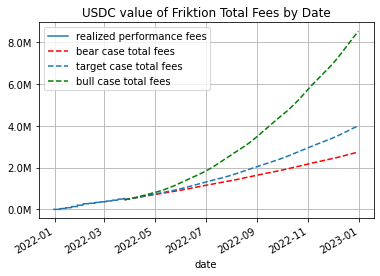

In [1085]:
total_fees = qp.set_index("date")["performance_fee"]+qp.set_index("date")["withdrawal_fee"]

ax = plt.figure().gca()
total_fees.plot(grid=True, ax=ax, label="realized performance fees")
plt.xticks(rotation=30)
ax.set_title("USDC value of Friktion Total Fees by Date")

ax.plot(y.future_tvl_bear.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="bear case total fees", linestyle='dashed', color='red')
ax.plot(y.future_tvl_realistic.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="target case total fees", linestyle='dashed', color='C0')
ax.plot(y.future_tvl_bull.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="bull case total fees", linestyle='dashed', color='green')

plt.legend()

ax.yaxis.set_major_formatter(formatter)

# V2

In [1086]:
tvl = ff.groupby("time").tvl.mean().reset_index()

In [1087]:
tvl

,time,tvl
0,2021-12-25 00:27:14,2.922707e+07
1,2021-12-25 01:05:51,2.956973e+07
2,2021-12-25 01:37:17,2.982349e+07
3,2021-12-25 02:10:46,2.992262e+07
4,2021-12-25 03:01:37,2.976328e+07
...,...,...
16118,2022-03-27 05:27:10,1.137418e+08
16119,2022-03-27 05:34:29,1.138311e+08
16120,2022-03-27 05:44:18,1.137830e+08
16121,2022-03-27 05:53:08,1.137426e+08


In [1088]:
tvl.groupby(pd.Grouper(key="time", freq="1W")).tvl.mean().sum()

1259889782.672162

In [1089]:
y = pd.DataFrame(pd.date_range('2022-03-26', '2022-12-31'))

y.columns = ["date"]
y["future_tvl_bull"] = (1+np.arange(1, y.shape[0]+1) * 0.025)*1.2e8*(1+np.sin(y.index/8)*0.10)
y["future_tvl_realistic"] = (1+np.arange(1, y.shape[0]+1) * 0.007)*1.2e8*(1+np.sin(y.index/10)*0.10)
y["future_tvl_bear"] = (1+np.arange(1, y.shape[0]+1) * 0.002)*1.2e8*(1+np.sin(y.index/10)*0.10)

In [1090]:
FEE_BPS = 0.0005

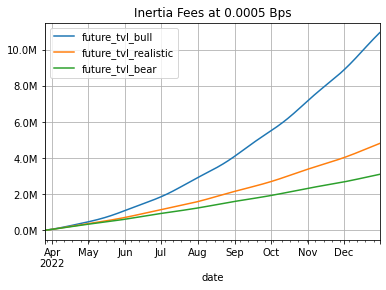

In [1091]:
ax = plt.figure().gca()

inertia_revenue = (y.groupby(pd.Grouper(key="date", freq="D"))[["future_tvl_bull", "future_tvl_realistic", "future_tvl_bear"]].mean()*FEE_BPS/7).cumsum()
inertia_revenue.plot(grid=True, title="Inertia Fees at {} Bps".format(FEE_BPS), ax=ax)

ax.yaxis.set_major_formatter(formatter)

In [1092]:
y=y.set_index("date")

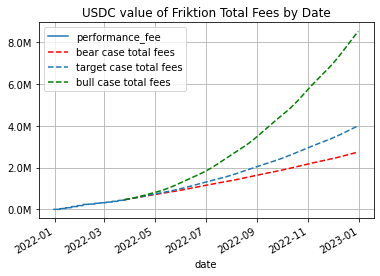

In [1093]:
ax = plt.figure().gca()

qp.set_index("date")[["performance_fee"]].plot(grid=True, ax=ax, label="realized performance fees")
plt.xticks(rotation=30)
ax.set_title("USDC value of Friktion Total Fees by Date")

ax.plot(y.future_tvl_bear.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="bear case total fees", linestyle='dashed', color='red')
ax.plot(y.future_tvl_realistic.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="target case total fees", linestyle='dashed', color='C0')
ax.plot(y.future_tvl_bull.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1], label="bull case total fees", linestyle='dashed', color='green')

plt.legend()

ax.yaxis.set_major_formatter(formatter)

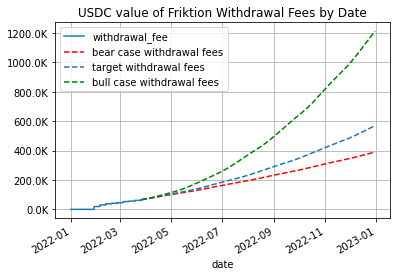

In [1094]:
ax = plt.figure().gca()

qp.set_index("date")[["withdrawal_fee"]].plot(grid=True, ax=ax)
plt.xticks(rotation=30)
ax.set_title("USDC value of Friktion Withdrawal Fees by Date")

ax.plot(y.future_tvl_bear.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="bear case withdrawal fees", linestyle='dashed', color='red')
ax.plot(y.future_tvl_realistic.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="target withdrawal fees", linestyle='dashed', color='C0')
ax.plot(y.future_tvl_bull.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1], label="bull case withdrawal fees", linestyle='dashed', color='green')

plt.legend()

ax.yaxis.set_major_formatter(formatter2)

total_fees_bear = y.future_tvl_bear.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_bear.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]
total_fees_target = y.future_tvl_realistic.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_realistic.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]
total_fees_bull = y.future_tvl_bull.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]+y.future_tvl_bull.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]

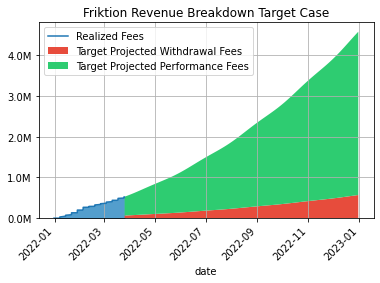

In [1095]:
target_withdrawal = y.future_tvl_realistic.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]

target_performance = y.future_tvl_realistic.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]

ax = plt.figure().gca()

total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(target_withdrawal.index, target_withdrawal, 
                 target_performance, colors=["#e74c3c", "#2ecc71"],labels=["Target Projected Withdrawal Fees", "Target Projected Performance Fees"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown Target Case")

ax.yaxis.set_major_formatter(formatter)

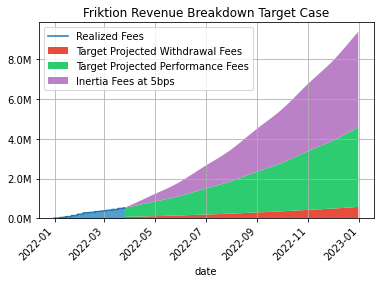

In [1096]:
ax = plt.figure().gca()
total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(target_withdrawal.index, target_withdrawal, target_performance, inertia_revenue.future_tvl_realistic,
                 colors=["#e74c3c", "#2ecc71", "#ba81c7"],labels=["Target Projected Withdrawal Fees", "Target Projected Performance Fees", "Inertia Fees at 5bps"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown Target Case")

ax.yaxis.set_major_formatter(formatter)

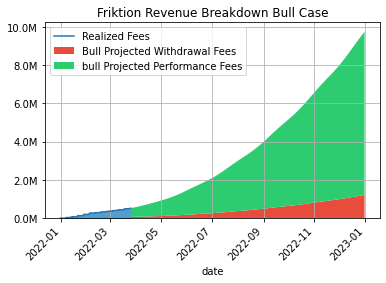

In [1097]:
bull_withdrawal = y.future_tvl_bull.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]

bull_performance = y.future_tvl_bull.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]

ax = plt.figure().gca()

total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(bull_withdrawal.index, bull_withdrawal, 
                 bull_performance, colors=["#e74c3c", "#2ecc71"],labels=["Bull Projected Withdrawal Fees", "bull Projected Performance Fees"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown Bull Case")

ax.yaxis.set_major_formatter(formatter)

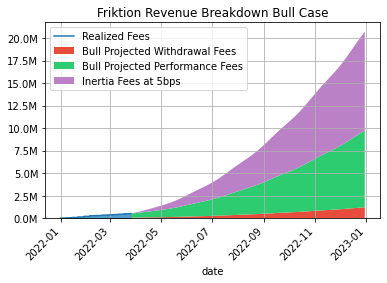

In [1098]:
ax = plt.figure().gca()
total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(bull_withdrawal.index, bull_withdrawal, bull_performance, inertia_revenue.future_tvl_bull,
                 colors=["#e74c3c", "#2ecc71", "#ba81c7"],labels=["Bull Projected Withdrawal Fees", "Bull Projected Performance Fees", "Inertia Fees at 5bps"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown Bull Case")

ax.yaxis.set_major_formatter(formatter)

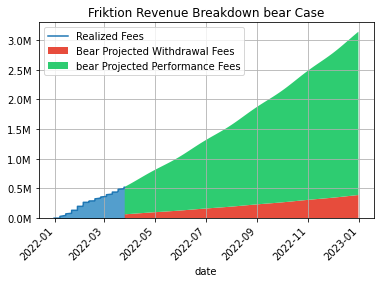

In [1099]:
bear_withdrawal = y.future_tvl_bear.cumsum()*churn_rate + qp.withdrawal_fee.iloc[-1]

bear_performance = y.future_tvl_bear.cumsum()*perf_fee_rate + qp.performance_fee.iloc[-1]

ax = plt.figure().gca()

total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(bear_withdrawal.index, bear_withdrawal, 
                 bear_performance, colors=["#e74c3c", "#2ecc71"],labels=["Bear Projected Withdrawal Fees", "bear Projected Performance Fees"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown bear Case")

ax.yaxis.set_major_formatter(formatter)

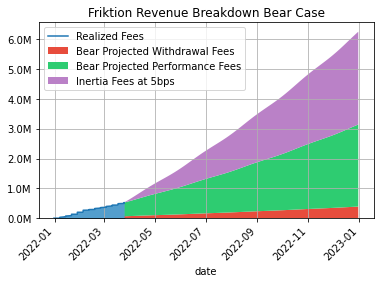

In [1100]:
ax = plt.figure().gca()
total_fees.plot(grid=True, ax=ax, label="Realized Fees")
ax.fill_between(total_fees.index, total_fees, color='#539ecd')

_ = ax.stackplot(bear_withdrawal.index, bear_withdrawal, bear_performance, inertia_revenue.future_tvl_bear,
                 colors=["#e74c3c", "#2ecc71", "#ba81c7"],labels=["Bear Projected Withdrawal Fees", "Bear Projected Performance Fees", "Inertia Fees at 5bps"])
plt.grid(True)
plt.xticks(rotation=45)

plt.legend(loc='upper left')

plt.title("Friktion Revenue Breakdown Bear Case")

ax.yaxis.set_major_formatter(formatter)

# ENTROPY

In [1101]:
# 

In [1102]:
deribit_avg_options_volume = 1e9

In [1103]:
entropy_market_share = 0.02

In [1104]:
entropy_daily_volume = entropy_market_share*deribit_avg_options_volume

In [1105]:
entropy_daily_volume

20000000.0

In [1106]:
ENTROPY_FEE = 0.005

In [1107]:
ENTROPY_FEE*entropy_daily_volume

100000.0

In [1108]:
yyy = y.reset_index()

hypothetical_entropy_market_share = (1+np.arange(1, yyy.shape[0]+1) * 0.6)*0.0001*(1+np.sin(yyy.index/7)*0.2)


In [1109]:
ms = pd.DataFrame(hypothetical_entropy_market_share)

ms.index = yyy.date

ms.columns=["entropy_market_share"]

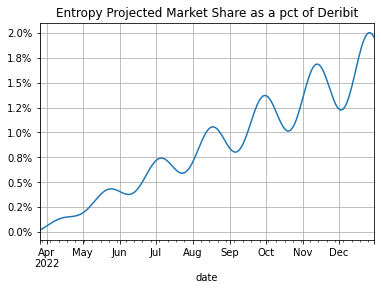

In [1116]:
ax=plt.figure().gca()
(ms.entropy_market_share).plot(title="Entropy Projected Market Share as a pct of Deribit", grid=True, ax=ax)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 


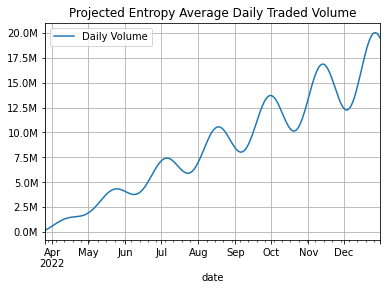

In [1115]:
qq = ms*deribit_avg_options_volume
qq.columns=["Daily Volume"]

ax = plt.figure().gca()

qq.plot(grid=True, ax=ax)
plt.title("Projected Entropy Average Daily Traded Volume")
ax.yaxis.set_major_formatter(formatter)

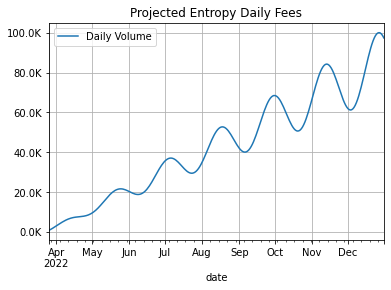

In [1050]:
ax = plt.figure().gca()

(qq*ENTROPY_FEE).plot(grid=True, ax=ax)
plt.title("Projected Entropy Daily Fees")
ax.yaxis.set_major_formatter(formatter2)

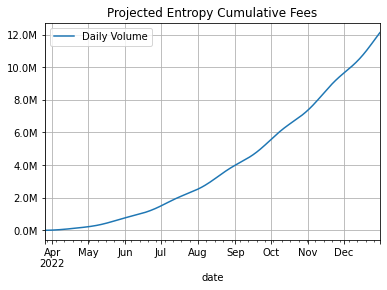

In [1118]:
ax = plt.figure().gca()

(qq*ENTROPY_FEE).cumsum().plot(grid=True, ax=ax)
plt.title("Projected Entropy Cumulative Fees")
ax.yaxis.set_major_formatter(formatter)